# Recurrent Neural Networks

## Univariate Time Series Regression

This notebook demonstrates how to forecast the S&P 500 index using a Recurrent Neural Network.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Get Data

We obtain data for 2010-2018 from the Federal Reserve Bank’s Data Service [FRED](https://fred.stlouisfed.org/) using the [pandas_datareader](https://pandas-datareader.readthedocs.io/) library in introduced in [Chapter 2 on Market and Fundamental Data](../02_market_and_fundamental_data).

[*********************100%***********************]  1 of 1 completed


Text(0.5, 0, '')

,SP500
Date,
2011-01-01,1286.119995
2011-02-01,1327.219971
2011-03-01,1325.829956
2011-04-01,1363.609985
2011-05-01,1345.199951
...,...
2020-09-01,3363.000000
2020-10-01,3269.959961
2020-11-01,3621.629883


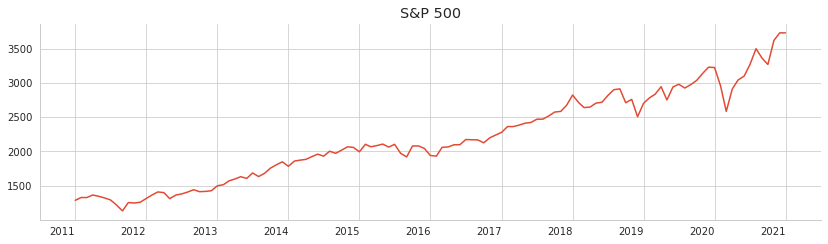

In [6]:
import yfinance as yf
sp500 = yf.download('^GSPC', period='10y', interval='1mo')['Adj Close']
sp500 = pd.DataFrame(sp500)
sp500.columns = ['SP500']
ax = sp500.plot(title='S&P 500', legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine();
sp500

## Preprocessing

In [7]:
scaler = MinMaxScaler()

In [8]:
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), index=sp500.index)
sp500_scaled.describe()

count    121.000000
mean       0.407107
std        0.249353
min        0.000000
25%        0.192858
50%        0.366870
75%        0.607670
max        1.000000
dtype: float64

## Generating recurrent sequences from our time series

Our time series is a sequence of numbers indexed by time:

$$x_{0},x_{1},x_{2},...,x_{T}$$

where $\{x_t\}$ is the numerical value in period $t$ and  $T$ is the total length of the series. 

To apply a RNN for regression of classification, we use a sliding window to construct a rolling set of input/output pairs for our model to learn from as animated below.

We will generate sequences of 63 trading days, approximately three months, and use a single LSTM layer with 20 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

Our S&P 500 sample has 2,264 observations or time steps. We will create overlapping sequences using a window of 63 observations each.
For a simpler window of size T = 5, we obtain input-output pairs as shown in the following table:

Generally speaking, for window size S, the relationship takes the form 

$$x_t = f( x_{t-1}, x_{t-2}, ..., x_{t-S}) \quad\forall t=S, S+1, ..., T$$

Each of the $T-S$ lagged input sequence or vector is of length S with a corresponding scalar output.

We can use the function create_univariate_rnn_data() to stack sequences selected using a rolling windows:

In [9]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

We apply this function to the rescaled stock index for a window_size=63 to obtain a two-dimensional dataset of shape number of samples x number of timesteps:

In [10]:
window_size = 63

In [11]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01,0.059486,0.075290,0.074755,0.089283,0.082203,0.072760,0.061854,0.033634,0.000000,0.046866,0.044428,0.048519,0.069595,0.090079,0.106532,...,0.332063,0.374172,0.360095,0.366870,0.375284,0.358257,0.373919,0.323292,0.303239,0.364505,0.364909,0.350886,0.311010,0.307930,0.356961
2016-05-01,0.075290,0.074755,0.089283,0.082203,0.072760,0.061854,0.033634,0.000000,0.046866,0.044428,0.048519,0.069595,0.090079,0.106532,0.102472,...,0.374172,0.360095,0.366870,0.375284,0.358257,0.373919,0.323292,0.303239,0.364505,0.364909,0.350886,0.311010,0.307930,0.356961,0.359099
2016-06-01,0.074755,0.089283,0.082203,0.072760,0.061854,0.033634,0.000000,0.046866,0.044428,0.048519,0.069595,0.090079,0.106532,0.102472,0.068795,...,0.360095,0.366870,0.375284,0.358257,0.373919,0.323292,0.303239,0.364505,0.364909,0.350886,0.311010,0.307930,0.356961,0.359099,0.371269
2016-07-01,0.089283,0.082203,0.072760,0.061854,0.033634,0.000000,0.046866,0.044428,0.048519,0.069595,0.090079,0.106532,0.102472,0.068795,0.088725,...,0.366870,0.375284,0.358257,0.373919,0.323292,0.303239,0.364505,0.364909,0.350886,0.311010,0.307930,0.356961,0.359099,0.371269,0.372004
2016-08-01,0.082203,0.072760,0.061854,0.033634,0.000000,0.046866,0.044428,0.048519,0.069595,0.090079,0.106532,0.102472,0.068795,0.088725,0.095323,...,0.375284,0.358257,0.373919,0.323292,0.303239,0.364505,0.364909,0.350886,0.311010,0.307930,0.356961,0.359099,0.371269,0.372004,0.400743


In [13]:
y.head()

Date
2016-04-01    0.359099
2016-05-01    0.371269
2016-06-01    0.372004
2016-07-01    0.400743
2016-08-01    0.399724
dtype: float64

In [14]:
X.shape

(58, 63)

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

Text(0.5, 0, '')

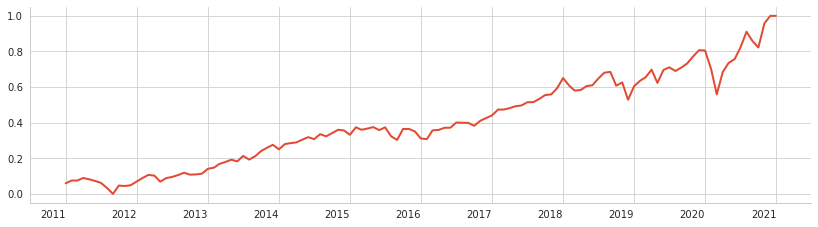

In [15]:
ax = sp500_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine();

In [16]:
X_train = X[:'2018'].values.reshape(-1, window_size, 1)
y_train = y[:'2018']

# keep the last year for testing
X_test = X['2020'].values.reshape(-1, window_size, 1)
y_test = y['2020']

In [17]:
n_obs, window_size, n_features = X_train.shape

In [18]:
y_train.shape

(33,)

## Keras LSTM Layer

Keras has several built-in RNN layers with various configuration options described in detail in the [documentation](https://keras.io/layers/recurrent/).

```
LSTM(units,
     activation='tanh',
     recurrent_activation='hard_sigmoid',
     use_bias=True,
     kernel_initializer='glorot_uniform',
     recurrent_initializer='orthogonal',
     bias_initializer='zeros',
     unit_forget_bias=True,
     kernel_regularizer=None,
     recurrent_regularizer=None,
     bias_regularizer=None,
     activity_regularizer=None,
     kernel_constraint=None,
     recurrent_constraint=None,
     bias_constraint=None,
     dropout=0.0,
     recurrent_dropout=0.0,
     implementation=1,
     return_sequences=False,
     return_state=False,
     go_backwards=False,
     stateful=False,
     unroll=False)
 ```

##  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [19]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

The summary shows that the model has 1,781 parameters:

In [20]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Train the Model

We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:

In [21]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [22]:
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

We define an EarlyStopping callback and train the model for up to 100 episodes. 

In [23]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

In [25]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

0018
Epoch 00020: val_loss did not improve from 0.00395
2/2 [==============================] - 0s 25ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 21/150
1/2 [==============>...............] - ETA: 0s - loss: 0.0022
Epoch 00021: val_loss did not improve from 0.00395
2/2 [==============================] - 0s 22ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 22/150
1/2 [==============>...............] - ETA: 0s - loss: 0.0016
Epoch 00022: val_loss did not improve from 0.00395
2/2 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 23/150
1/2 [==============>...............] - ETA: 0s - loss: 0.0014
Epoch 00023: val_loss did not improve from 0.00395
2/2 [==============================] - 0s 19ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 24/150
1/2 [==============>...............] - ETA: 0s - loss: 0.0021
Epoch 00024: val_loss improved from 0.00395 to 0.00384, saving model to results/univariate_time_series/rnn.h5
2/2 [==============================] 

Training stops after 51 epochs; the `early_stopping` callback restores the weights for the best model (after 41 epochs)

## Evaluate model performance

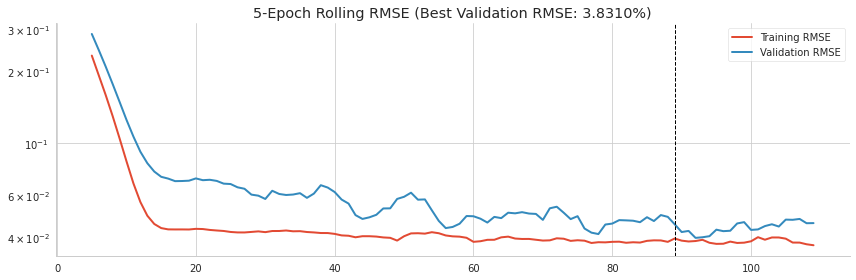

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [27]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0404 | Test RMSE: 0.0383


In [28]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

In [29]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9295 | Test IC: 0.8671


### Rescale predictions

In [30]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

In [31]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [32]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 104.94 | Test RMSE: 99.63'

In [33]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict
sp500 = sp500.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

### Plot Results

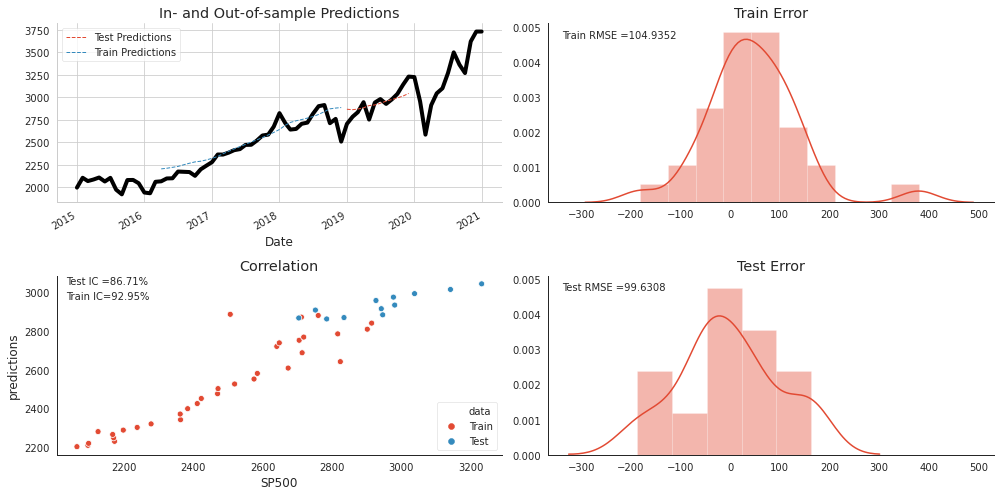

In [34]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

sp500.loc['2015':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500.loc['2015':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);